In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [121]:
df = pd.read_csv("../data/private/0_raw_EbolaDatabase.csv")
df_in = df.copy()

In [120]:
if 'study_id' in df.columns:
    df.set_index('study_id', inplace=True)
df.head(0) # DO NOT PUSH A COMMIT WHERE ANY LINE IS VISIBLE!

,evd,evd_ct,malaria,death,sex,age,quarantine,days_admitted,referral_time,date_admis,...,hemoptysis_after,hematochezia_after,hematuria_after,gyne_hemorrhage_after,num_hemorrhage_sites_after,dehydration_after,hepatomegaly_after,jaundice_after,edema_after,splenomegaly_after
study_id,,,,,,,,,,,,,,,,,,,,,


In [95]:
print(df.shape)
# Show which columns contain any NA values:
df.isna().any().to_frame().T

(575, 67)


,study_id,evd,evd_ct,malaria,death,sex,age,quarantine,days_admitted,referral_time,...,hemoptysis_after,hematochezia_after,hematuria_after,gyne_hemorrhage_after,num_hemorrhage_sites_after,dehydration_after,hepatomegaly_after,jaundice_after,edema_after,splenomegaly_after
0,False,False,True,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [96]:
df[df.columns[df.isna().any()]].isna().sum().to_frame().T

,evd_ct,malaria,quarantine,referral_time
0,431,32,24,87


In [97]:
print("evd_ct is available for {ct} of the {pos} EVD+ patients.".format(
        ct=len(df) - df['evd_ct'].isna().sum(),
        pos=df['evd'].sum()
))

evd_ct is available for 144 of the 158 EVD+ patients.


The first four columns are the most obvious targets (`evd`, `evd_ct`, `malaria` and `death`).
The first three could be particularly useful in predicting `death`.

Every patient admitted to the ETC was tested for Ebola (column `evd`).
`evd_ct` (inversely proportional to the viral load) is missing for all EVD- patients and for 14 EVD+ patients.
Malaria test results are missing for 32 patients.

Annie's paper mentions 20 missing values for the referral time, which were tested to be likely missing completely at random (MCAR).
She transforms this into the binary variable $\mathbb{1}\left\{ x \in [4, 9] \right\}$ ($x \triangleq$ referral time in days).
Let's plot the proportion of EVD(+) as a function of referral time, along with a Wilson score interval obtained by assuming that the EVD diagnosis follows a Bernoulli distribution whose probability depends on the referral time.

In [98]:
df_ref = df['evd'].to_frame()
df_ref['referral_time'] = df['referral_time'].astype(str).apply(
        lambda s: s[:-2] if ('na' in s.lower() or len(s)==4) else '0'+s[:-2]
)
df_ref['total'] = 1
df_ref.head()

,evd,referral_time,total
0,1,12,1
1,1,n,1
2,1,06,1
3,1,01,1
4,1,n,1


Text(0, 0.5, 'number of patients')

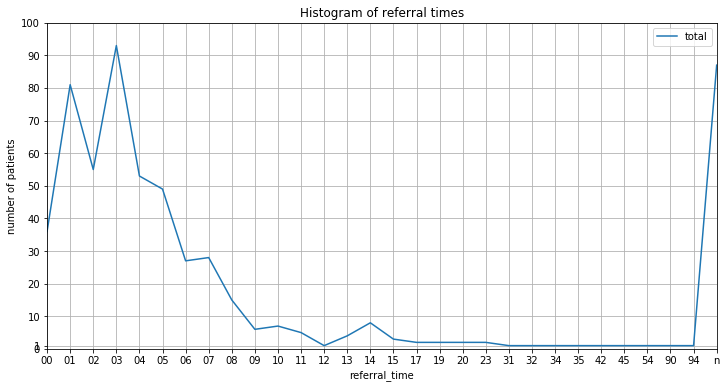

In [99]:
df_ref = df_ref.groupby('referral_time').sum()
df_ref.plot(y='total', xticks=range(len(df_ref)), figsize=(12,6), grid=True, ylim=(0,100), yticks=[0,1]+list(range(10,101, 10)), title='Histogram of referral times')
plt.ylabel("number of patients")

On second thought, these intervals (and also the proportion of EVD(+) patients in each `referral_time` category will be near meaningless, considering the small number of samples per category.
Instead, we follow Annie in replacing the referral_time by a binary variable (cf. previous Markdown cell).
In this new binary feature, we replace `NaN`s by the proportion of `1`s among available values. With this, the feature is no longer truly binary, but can instead be interpreted as an a-priori probability of having a referral time in between 4 and 9 days.

In [122]:
df['referral(4-9)'] = ((df['referral_time'] <= 9) & (df['referral_time'] >= 4)).astype(np.float32)
df.loc[ np.where(np.isnan(df['referral_time']))[0] , 'referral(4-9)'] = float('NaN')
df.loc[:, ['referral_time', 'referral(4-9)']].head(10).T

,0,1,2,3,4,5,6,7,8,9
referral_time,12.0,NaN,6.0,1.0,NaN,3.0,7.0,1.0,10.0,NaN
referral(4-9),0.0,NaN,1.0,0.0,NaN,0.0,1.0,0.0,0.0,NaN


In [123]:
df.loc[ np.where(np.isnan(df['referral_time']))[0] , 'referral(4-9)'] = df['referral(4-9)'].mean()
df.loc[:, ['referral_time', 'referral(4-9)']].head(10).T

,0,1,2,3,4,5,6,7,8,9
referral_time,12.0,NaN,6.0,1.0,NaN,3.0,7.0,1.0,10.0,NaN
referral(4-9),0.0,0.364754,1.0,0.0,0.364754,0.0,1.0,0.0,0.0,0.364754


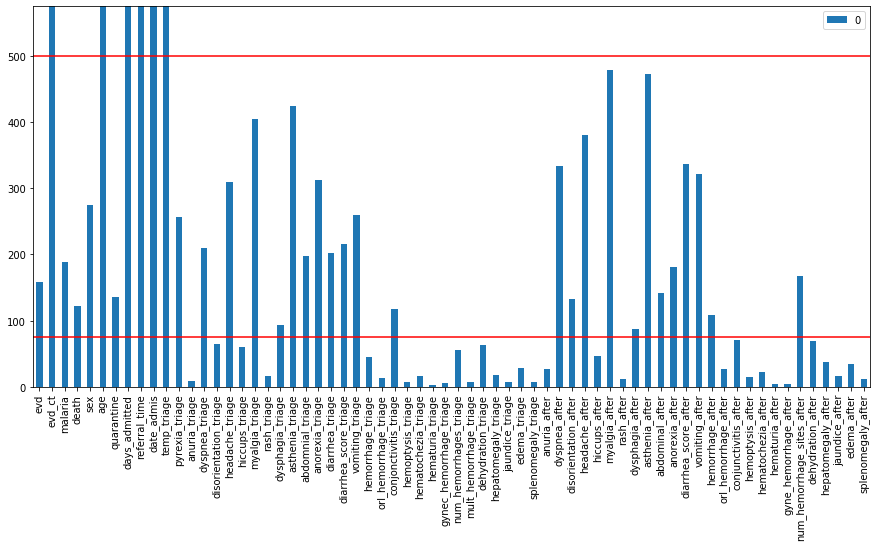

In [19]:
# Many columns are binary. Let's count the positives (meaningless for non-binary features):
df.sum().to_frame().plot(kind='bar', figsize=(15,7))
plt.gca().set_ylim((0, len(df)))
hline_limit = 75
plt.gca().axhline(y=hline_limit, color='r')
plt.gca().axhline(y=len(df) - hline_limit, color='r')
plt.show()

One possibility for dealing with continuous or ordered features for which values are missing not completely at random (not MCAR), at least for ridge or logistic regression:

1. Standardize the features if you're going to use regularization (and why wouldn't you)
2. Add a one-hot encoded feature "feature_XY_is_na" (this feature should be non-zero when the other feature _is_ missing).
3. Replace the na values by 0.

Result: one weight learns what to contribute to the model when the feature is na, and another learns what to do when it is available. This could, for instance, result in different intercepts for people with vs without missing value, which makes sense if the values are missing for some systematic reason. It's kind of a backwards logic of "if the Doctor didn't deem it useful to perform this test, that's probably because the person was fine" or something.

Main downside: If the number of missing values is low, 